In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import muon as mu
import networkx as nx
import scvi
import glob
import scglue
import os
from scipy import sparse
import matplotlib.pyplot as plt
import rpy2
from rpy2.robjects import r
from rpy2.robjects import pandas2ri
import anndata2ri

anndata2ri.activate()
pandas2ri.activate()

sc.settings.verbosity = 3
sc.settings.n_jobs = 8
sc.set_figure_params(dpi = 100, dpi_save = 300, figsize=(5,5), frameon = False)
scvi.train.Trainer(accelerator = 'mps')
%config InlineBackend.figure_format='retina'
%load_ext rpy2.ipython

Global seed set to 0
/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
INFO:rpy2.situation:cffi mode is CFFI_MODE.ANY
INFO:rpy2.situation:R home found: /Library/Frameworks/R.framework/Resources
INFO:rpy2.situation:R library path: 
INFO:rpy2.situation:LD_LIBRARY_PATH: 
INFO:rpy2.rinterface_lib.embedded:Default options to initialize R: rpy2, --quiet, --no-save
INFO:rpy2.rinterface_lib.embedded:R is already initialized. No need to initialize.
GPU available:

# Data prep

## Nguyen

In [2]:
nguyen = pd.read_csv('../TG_data/Nguyen/GSE101984_cells.csv', index_col=0)
nguyen.set_index('GENE', inplace=True)

In [3]:
nguyen = sc.AnnData(nguyen.T, dtype=np.float32)
nguyen.X = sparse.csr_matrix(nguyen.X)
sc.pp.filter_cells(nguyen, min_genes=150)
sc.pp.filter_genes(nguyen, min_cells=3)
nguyen.var['mt'] = nguyen.var_names.str.startswith('mt')
sc.pp.calculate_qc_metrics(nguyen, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
nguyen = nguyen[(nguyen.obs['n_genes_by_counts'] < 2500) & (nguyen.obs['pct_counts_mt'] < 5)].copy()
nguyen.obs['Technology'] = 'DropSeq'
nguyen.obs['Conditions'] = 'Naive'
nguyen.obs['Time'] = '0day'
nguyen.obs['Strains'] = 'C57'
nguyen.obs['Tissue'] = 'TG'
nguyen.obs['Source'] = 'Nguyen'
nguyen.obs['Sex'] = 'female'
id = nguyen[nguyen[: , 'Uty'].X > 0, :].obs_names
nguyen.obs.Sex.loc[id] = 'male'
nguyen.layers["counts"] = nguyen.X.copy()

filtered out 421 cells that have less than 150 genes expressed
filtered out 2907 genes that are detected in less than 3 cells


/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_16513/1518064313.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nguyen.obs.Sex.loc[id] = 'male'


## Jia

In [4]:
%%R -o jia_df
# Original code was from
# https://github.com/altairwei/rhapsodykit/blob/master/R/data.R
library(dplyr)
read_expression_st <- function(x) {
  message(sprintf("Reading %s", x))
  df <- readr::read_tsv(x, comment = "#", progress = TRUE,
    col_types = readr::cols(
      Cell_Index = readr::col_character()
    )
  )

  message("Matrix constructing...")
  df <- df %>%
    dplyr::select(Cell_Index, Gene, RSEC_Adjusted_Molecules)

  colindex <- unique(df$Cell_Index)
  rowindex <- unique(df$Gene)

  # The locations of the non-zero values (RSEC_Adjusted_Molecules)
  colpos <- match(df$Cell_Index, colindex)
  rowpos <- match(df$Gene, rowindex)

  mtx <- Matrix::sparseMatrix(
    i = rowpos,
    j = colpos,
    x = df$RSEC_Adjusted_Molecules,
    use.last.ij = TRUE,
    repr = "C",
    dimnames = list(rowindex, colindex),
  )

  mtx
}

jia_mtx <- read_expression_st('../TG_data/Jia/GSM6572776_TG_Expression_Data.st.txt')
jia_df <- as.data.frame(as.matrix(jia_mtx))

Attaching package: ‘dplyr’



    filter, lag



    intersect, setdiff, setequal, union






In [5]:
jia_meta = pd.read_table('../TG_data/Jia/GSE213105_cell_barcodes_ID.txt', index_col=0)

In [6]:
jia = sc.AnnData(jia_df.T, dtype=np.float32, obs=jia_meta)
jia.X = sparse.csr_matrix(jia.X)
jia.var_names_make_unique()
sc.pp.filter_cells(jia, min_genes=200)
sc.pp.filter_genes(jia, min_cells=10)
jia.var['mt'] = jia.var_names.str.startswith('mt')
sc.pp.calculate_qc_metrics(jia, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
jia.obs['Tissue'] = 'TG'
jia.obs['Conditions'] = 'Naive'
jia.obs['Time'] = '0day'
jia.obs['Technology'] = 'BD'
jia.obs['Strains'] = 'C57'
jia.obs['Source'] = 'Jia'
jia.obs['Sex'] = 'female'
id = jia[jia[: , 'Uty'].X > 0, :].obs_names
jia = jia[(jia.obs['n_genes_by_counts'] < 2500) & (jia.obs['pct_counts_mt'] < 15)].copy()

/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


filtered out 950 cells that have less than 200 genes expressed
filtered out 15578 genes that are detected in less than 10 cells


## Liu

In [7]:
fpaths = glob.glob('../TG_data/Liu/GSE186421_RAW/*')
fpaths

['../TG_data/Liu/GSE186421_RAW/GSM5651455_3_WTA_CFA',
 '../TG_data/Liu/GSE186421_RAW/GSM5651454_1_WTA_Naive']

In [8]:
def load_Liu(data_dir:str):
    prefix = data_dir.split('/')[-1]
    condition = prefix.split('_')[-1]
    adata = sc.read_mtx(f'{data_dir}/matrix.mtx.gz').T
    adata.obs_names = pd.read_csv(f'{data_dir}/barcodes.tsv.gz', sep='\t', header=None, compression='gzip', dtype=str)[0].values
    adata.var_names = pd.read_csv(f'{data_dir}/features.tsv.gz', sep='\t', header=None, compression='gzip', dtype=str)[0].values
    adata.var_names_make_unique()
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=5)
    adata.var['mt'] = adata.var_names.str.startswith('mt')
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    adata.obs['Tissue'] = 'TG'
    adata.obs['Conditions'] = condition
    adata.obs['Technology'] = 'BD'
    adata.obs['Strains'] = 'C57'
    adata.obs['Sex'] = 'male'
    adata.obs['Source'] = 'Liu'
    adata = adata[(adata.obs['n_genes_by_counts'] < 2000) & (adata.obs['pct_counts_mt'] < 15)].copy()
    return adata

In [9]:
liu_adatas = list(map(load_Liu, fpaths))

filtered out 313 cells that have less than 200 genes expressed
filtered out 11993 genes that are detected in less than 5 cells
filtered out 405 cells that have less than 200 genes expressed
filtered out 12940 genes that are detected in less than 5 cells


In [10]:
liu_adatas[0].obs['Time'] = '7day'
liu_adatas[1].obs['Time'] = '0day'

## Renthal

In [11]:
%%R
suppressPackageStartupMessages({
    library(SingleCellExperiment)
    library(Seurat)
})


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [12]:
%%R
renthal_atac <- readRDS('../TG_data/Renthal/snATAC-seq_mouse_raw_counts.RDS')
renthal_rna <- readRDS('../TG_data/Renthal/snRNA-seq_mouse_raw_counts.RDS')
renthal_atac_meta <- read.csv('../TG_data/Renthal/snATAC-seq_mouse_barcode_meta.csv', row.names=1)
renthal_rna_meta <- read.csv('../TG_data/Renthal/snRNA-seq_mouse_barcode_meta.csv')

In [13]:
%%R
renthal_rna_se <- Seurat::CreateSeuratObject(counts = renthal_rna, assay = "RNA", min.cells = 10)
renthal_rna_meta <- read.csv('../TG_data/Renthal/snRNA-seq_mouse_barcode_meta.csv', row.names=colnames(renthal_rna_se))
renthal_rna_meta$V1 <- NULL
renthal_rna_se <- Seurat::AddMetaData(renthal_rna_se, metadata = renthal_rna_meta)

In [14]:
%%R
renthal_peak_se <- Seurat::CreateSeuratObject(counts = renthal_atac, assay = "peaks", min.cells = 5)
renthal_peak_se <- Seurat::AddMetaData(renthal_peak_se, metadata = renthal_atac_meta)

In [15]:
%%R
renthal_rna_se@meta.data <- renthal_rna_se@meta.data %>% mutate(Tissue = 'TG', Strains = 'C57', Sex=sex, Source='Renthal_RNA'
                                        #  Technology=ifelse(realtime == 6, 'inDrops', '10x'),
                                        #  Time=ifelse(model == "Naive", '0day', paste0(realtime,'day')),
                                        #  Conditions=model, Strains='C57'
                                         )

In [16]:
%%R
renthal_peak_se@meta.data <- renthal_peak_se@meta.data %>% mutate(Tissue = 'TG', Technology = '10x', Strains = 'C57', Source='Renthal_ATAC',
                                     Sex=ifelse(replicate == 1, 'male', 'pooled'),
                                     Time='0day', Conditions='Naive', Strains='C57')

In [17]:
%%R -o renthal_peak_sce -o renthal_rna_sce
renthal_rna_sce <- as.SingleCellExperiment(renthal_rna_se)
renthal_peak_sce <- as.SingleCellExperiment(renthal_peak_se)

/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/anndata2ri/r2py.py:106: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)
/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/anndata2ri/r2py.py:106: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)
/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/anndata2ri/r2py.py:106: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version 

In [18]:
renthal_rna_sce.var['mt'] = renthal_rna_sce.var_names.str.startswith('mt')
sc.pp.calculate_qc_metrics(renthal_rna_sce, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [19]:
renthal_rna_sce.obs['Conditions'] = renthal_rna_sce.obs.model
renthal_rna_sce.obs.Conditions[renthal_rna_sce.obs.Conditions == 'Control'] = 'Naive'
renthal_rna_sce.obs['Time'] = '0day'
renthal_rna_sce.obs.Time[renthal_rna_sce.obs.Conditions != 'Naive'] = renthal_rna_sce.obs.realtime[renthal_rna_sce.obs.Conditions != 'Naive'].astype(str) + 'day'
renthal_rna_sce.obs.Time = renthal_rna_sce.obs.Time.str.replace('.0','')
renthal_rna_sce.obs['Strains'] = 'C57'
renthal_rna_sce.obs['Technology'] = '10x'
renthal_rna_sce.obs.Technology[renthal_rna_sce.obs.realtime == 6] = 'inDrops'
renthal_rna_sce.obs.Sex = renthal_rna_sce.obs.Sex.str.lower()

/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_16513/734381868.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renthal_rna_sce.obs.Conditions[renthal_rna_sce.obs.Conditions == 'Control'] = 'Naive'
/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_16513/734381868.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renthal_rna_sce.obs.Time[renthal_rna_sce.obs.Conditions != 'Naive'] = renthal_rna_sce.obs.realtime[renthal_rna_sce.obs.Conditions != 'Naive'].astype(str) + 'day'
/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_16513/734381868.py:8: SettingWithCopyWarning: 
A value is trying 

In [20]:
new_time = dict(zip(['1day', '1.5day', '6day', '24day'],['0.0417day','0.0625day','0.25day','1day']))
renthal_rna_sce.obs.Time = renthal_rna_sce.obs.Time.map(lambda x: new_time.get(x, x))

## Lab

In [21]:
lab_tg = sc.read_h5ad('../TG_data/Lab/02_adata_tg.h5ad')

In [22]:
lab_tg.obs['Conditions'] = 'Naive'
lab_tg.obs['Time'] = '0day'
lab_tg.obs['Stains'] = 'C57'
lab_tg.obs['Technology'] = 'SS3'
lab_tg.obs['Source'] = 'Lab'
lab_tg.obs['Sex'] = 'female'
id = lab_tg[lab_tg[: , 'Uty'].X > 0, :].obs_names
lab_tg.obs.Sex.loc[id] = 'male'
lab_tg.layers["counts"] = lab_tg.X.copy()

/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_16513/3630137713.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lab_tg.obs.Sex.loc[id] = 'male'


In [23]:
del lab_tg.layers['umi']
del lab_tg.layers['read']

# Merge the anndata objects and preprocess

## RNA

In [24]:
TG_rna = sc.concat(liu_adatas + [jia, nguyen, renthal_rna_sce, lab_tg], join='outer')
TG_rna.layers['counts'] = TG_rna.X.copy()
TG_rna.obs_names_make_unique()

/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [25]:
del TG_rna.layers['logcounts']

In [26]:
TG_rna.obs = TG_rna.obs[['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'Tissue', 'Conditions',
                         'Source', 'Technology', 'Strains', 'Sex', 'Time', 'subtype']].copy()

In [27]:
TG_rna.obs.subtype.fillna('Unknown', inplace=True)

In [28]:
sc.pp.filter_genes(TG_rna, min_cells=25)

filtered out 8018 genes that are detected in less than 25 cells


In [29]:
TG_rna.var['mt'] = TG_rna.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(TG_rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [30]:
TG_rna.write_h5ad("../TG_data/Results/TG_rna_raw_counts.h5ad")

... storing 'Tissue' as categorical
... storing 'Conditions' as categorical
... storing 'Source' as categorical
... storing 'Technology' as categorical
... storing 'Strains' as categorical
... storing 'Sex' as categorical
... storing 'Time' as categorical
... storing 'subtype' as categorical


In [66]:
sc.pp.normalize_total(TG_rna)
sc.pp.log1p(TG_rna)
TG_rna.raw = TG_rna
sc.pp.highly_variable_genes(TG_rna, n_top_genes=5000, flavor="seurat_v3", layer='counts', batch_key='Source')

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [68]:
sc.pp.scale(TG_rna)
sc.tl.pca(TG_rna, n_comps=50, svd_solver='arpack')

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:19)


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:20)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:58)


... storing 'Tissue' as categorical
... storing 'Conditions' as categorical
... storing 'Source' as categorical
... storing 'Technology' as categorical
... storing 'Strains' as categorical
... storing 'Sex' as categorical
... storing 'Time' as categorical
... storing 'subtype' as categorical
/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


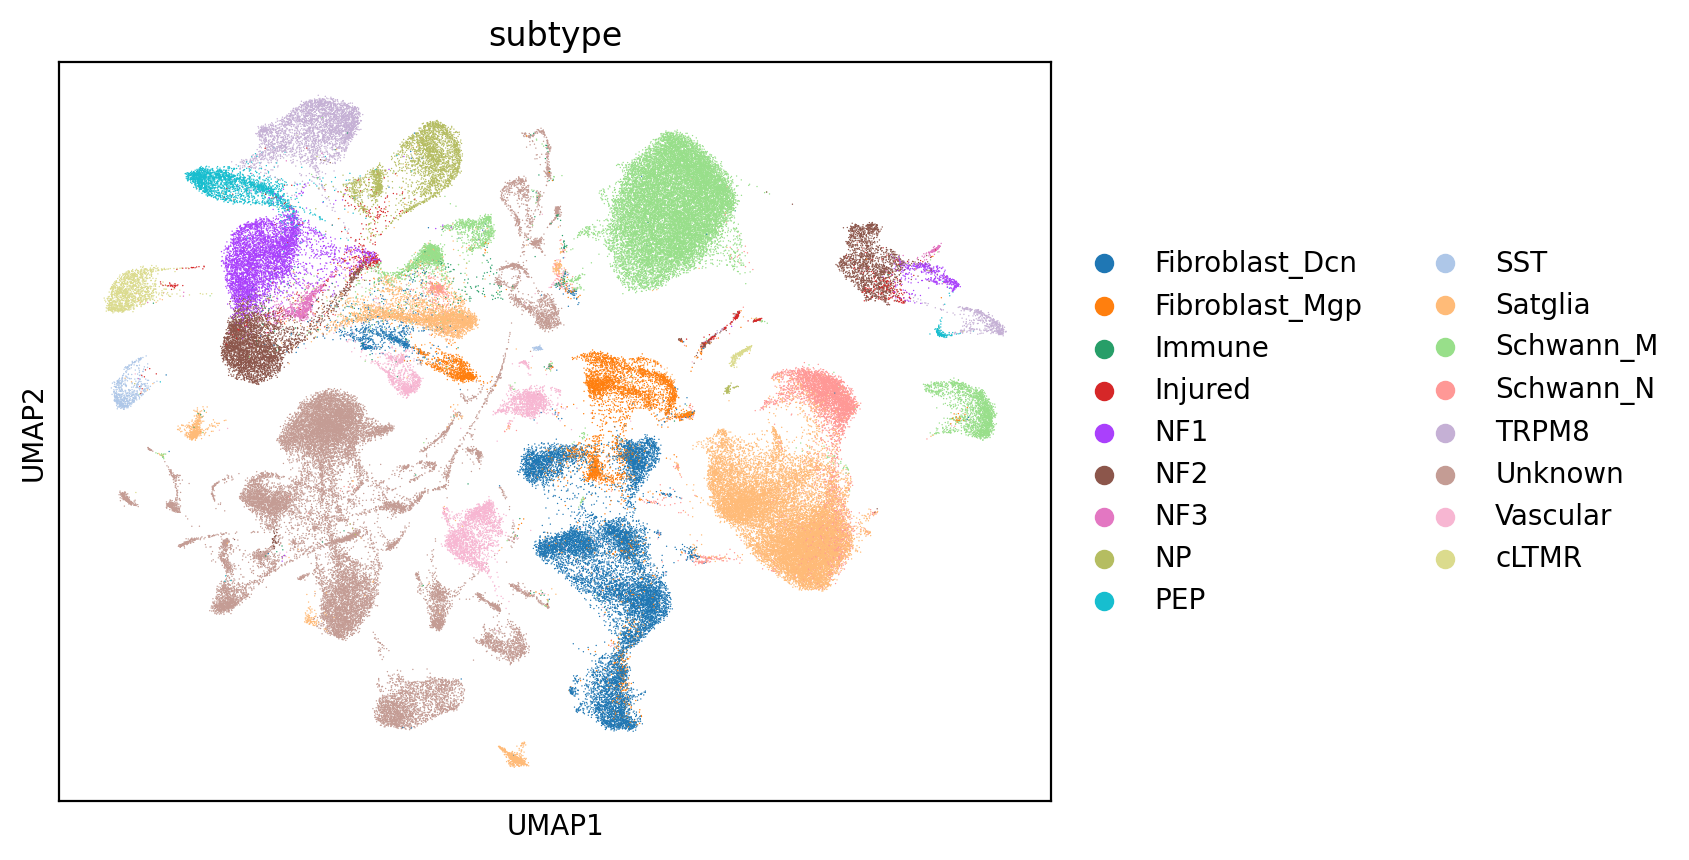

In [69]:
sc.pp.neighbors(TG_rna, metric="cosine")
sc.tl.umap(TG_rna)
sc.pl.umap(TG_rna, color="subtype")

/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


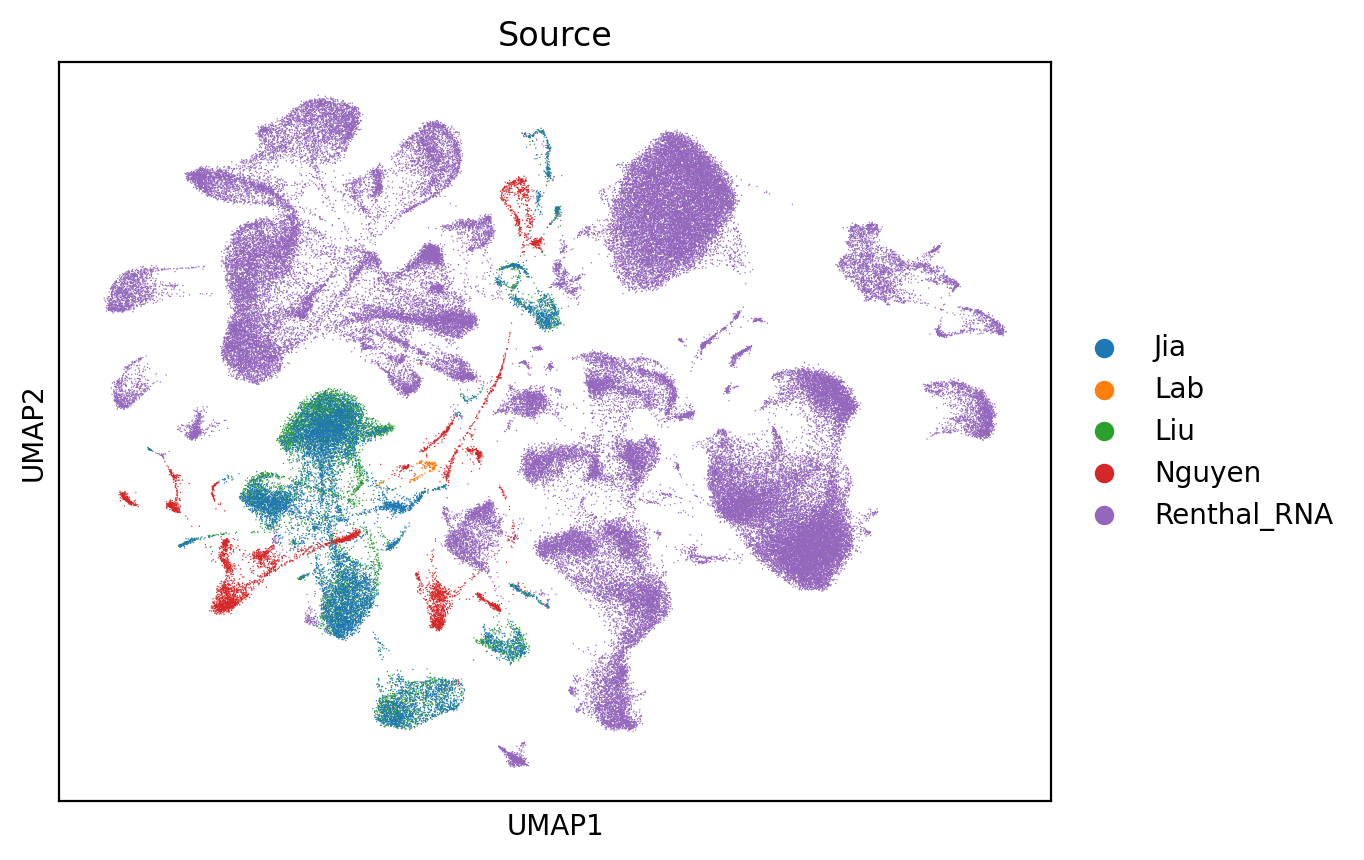

In [70]:
sc.pl.umap(TG_rna, color="Source")

In [71]:
scglue.data.get_gene_annotation(
    TG_rna, gtf="../TG_data/Mus_musculus.GRCm38.98.gtf",
    gtf_by="gene_name"
)
TG_rna.var.loc[:, ["chrom", "chromStart", "chromEnd"]].head()

/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/scglue/genomics.py:296: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  loaded = pd.read_csv(fname, sep="\t", header=None, comment="#")


chrom  chromStart    chromEnd
0610005C13Rik     7  45567793.0  45575327.0
0610006L08Rik     7  74818817.0  74853813.0
0610007N19Rik   NaN         NaN         NaN
0610007P14Rik   NaN         NaN         NaN
0610009B22Rik    11  51685385.0  51688874.0

In [72]:
TG_rna = TG_rna[:,TG_rna.var.dropna().index].copy()

In [73]:
TG_rna.var[["chromStart", "chromEnd"]] = TG_rna.var[["chromStart", "chromEnd"]].astype(int)

In [74]:
TG_rna.var['chrom'] = 'chr' +  TG_rna.var['chrom'].astype(str)

## ATAC

In [77]:
TG_atac = renthal_peak_sce.copy()
TG_atac.layers['counts'] = TG_atac.X.copy()
TG_atac.obs['Source'] = 'Renthal_ATAC'

In [78]:
del TG_atac.layers['logcounts']

In [79]:
scglue.data.lsi(TG_atac, n_components=50, n_iter=50)

In [80]:
sc.pp.neighbors(TG_atac, use_rep="X_lsi", metric="cosine")
sc.tl.umap(TG_atac)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


... storing 'subtype' as categorical
... storing 'Tissue' as categorical
... storing 'Technology' as categorical
... storing 'Strains' as categorical
... storing 'Source' as categorical
... storing 'Sex' as categorical
... storing 'Time' as categorical
... storing 'Conditions' as categorical
/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


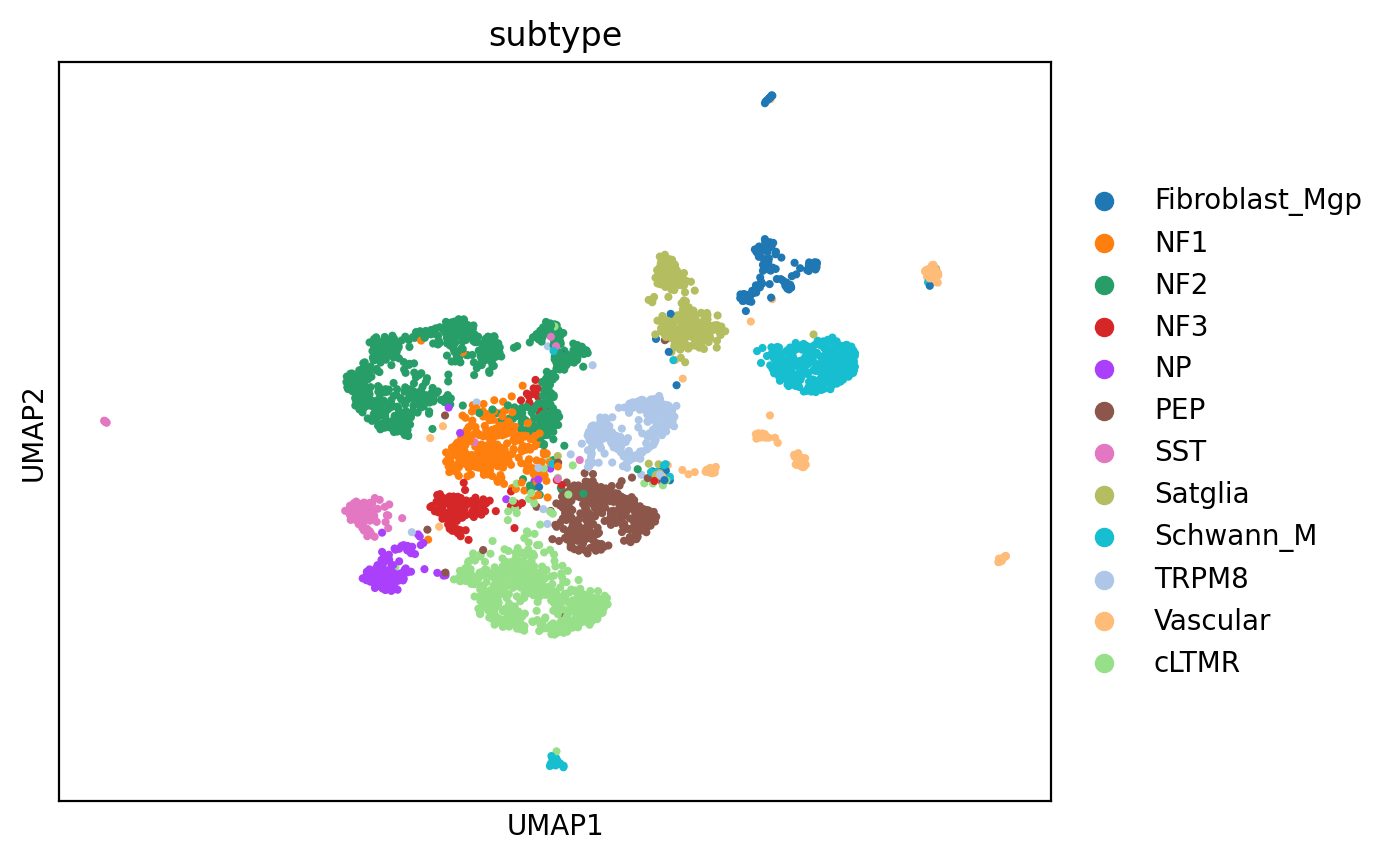

In [81]:
sc.pl.umap(TG_atac, color="subtype")

In [82]:
split = TG_atac.var_names.str.split(r"[:-]")
TG_atac.var["chrom"] = split.map(lambda x: x[0])
TG_atac.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
TG_atac.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
TG_atac.var.head()

chrom  chromStart  chromEnd
chr1:3113565-3113966  chr1     3113565   3113966
chr1:3119799-3120666  chr1     3119799   3120666
chr1:3121251-3121767  chr1     3121251   3121767
chr1:3182307-3182936  chr1     3182307   3182936
chr1:3204087-3204294  chr1     3204087   3204294

In [84]:
TG_atac.raw = TG_atac

# Graph construction

In [85]:
guidance = scglue.genomics.rna_anchored_guidance_graph(TG_rna, TG_atac)

window_graph:   0%|          | 0/12509 [00:00<?, ?it/s]

In [86]:
scglue.graph.check_graph(guidance, [TG_rna, TG_atac])

[INFO] check_graph: Checking variable coverage...


INFO:check_graph:Checking variable coverage...


[INFO] check_graph: Checking edge attributes...


INFO:check_graph:Checking edge attributes...


[INFO] check_graph: Checking self-loops...


INFO:check_graph:Checking self-loops...


[INFO] check_graph: Checking graph symmetry...


INFO:check_graph:Checking graph symmetry...


[INFO] check_graph: All checks passed!


INFO:check_graph:All checks passed!


In [87]:
TG_rna.write("../TG_data/Results/TG_rna_pp1.h5ad", compression="gzip")

... storing 'chrom' as categorical
... storing 'score' as categorical
... storing 'strand' as categorical
... storing 'thickStart' as categorical
... storing 'thickEnd' as categorical
... storing 'itemRgb' as categorical
... storing 'blockCount' as categorical
... storing 'blockSizes' as categorical
... storing 'blockStarts' as categorical
... storing 'gene_version' as categorical
... storing 'gene_source' as categorical
... storing 'gene_biotype' as categorical


# Use pretrain SCANVI model to predict TG_rna cell-types

The trained SCANVI model from DRG data is used

In [88]:
lvae = scvi.model.SCANVI.load('./scanvi_model')
lvae.to_device('cpu')

INFO     File ./scanvi_model/model.pt already downloaded                                                           


INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO:jax._src.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


In [96]:
TG_rna_mo = TG_rna.copy()
TG_rna_mo.X = TG_rna_mo.layers['counts'].copy()
del TG_rna_mo.varm

In [101]:
lvae.prepare_query_anndata(TG_rna_mo, reference_model=lvae)
TG_rna_mo.obs['celltype_scanvi'] = 'Unknown'

INFO     Found 80.03998667110963% reference vars in query data.                                                    


/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/scvi/model/base/_archesmixin.py:210: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_padding = AnnData(
/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/anndata/_core/merge.py:942: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [102]:
query_model = scvi.model.SCANVI.load_query_data(TG_rna_mo, lvae)

In [104]:
surgery_epochs = 50
train_kwargs_surgery = {
    "early_stopping": True,
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

query_model.train(max_epochs=surgery_epochs, **train_kwargs_surgery)

INFO     Training for 50 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 50/50: 100%|██████████| 50/50 [46:23<00:00, 54.00s/it, loss=639, v_num=1]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [46:23<00:00, 55.67s/it, loss=639, v_num=1]


In [109]:
del TG_rna_mo.var

In [110]:
query_model.save('./SCANVI_TG_DRG', overwrite=True, save_anndata=True)

In [129]:
# TG_rna.obs["scANVI_pred"] = query_model.predict()
TG_rna.obsm["X_scANVI"] = query_model.get_latent_representation()

In [125]:
fig, ax = plt.subplots(figsize=(5,5))
query_model.history['elbo_train'].plot(ax=ax, label='train')
query_model.history['elbo_validation'].plot(ax=ax, label='validation')
fig.show()

/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_42289/4084859552.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [130]:
sc.pp.neighbors(TG_rna, metric="cosine", use_rep="X_scANVI")
sc.tl.umap(TG_rna)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:49)


/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


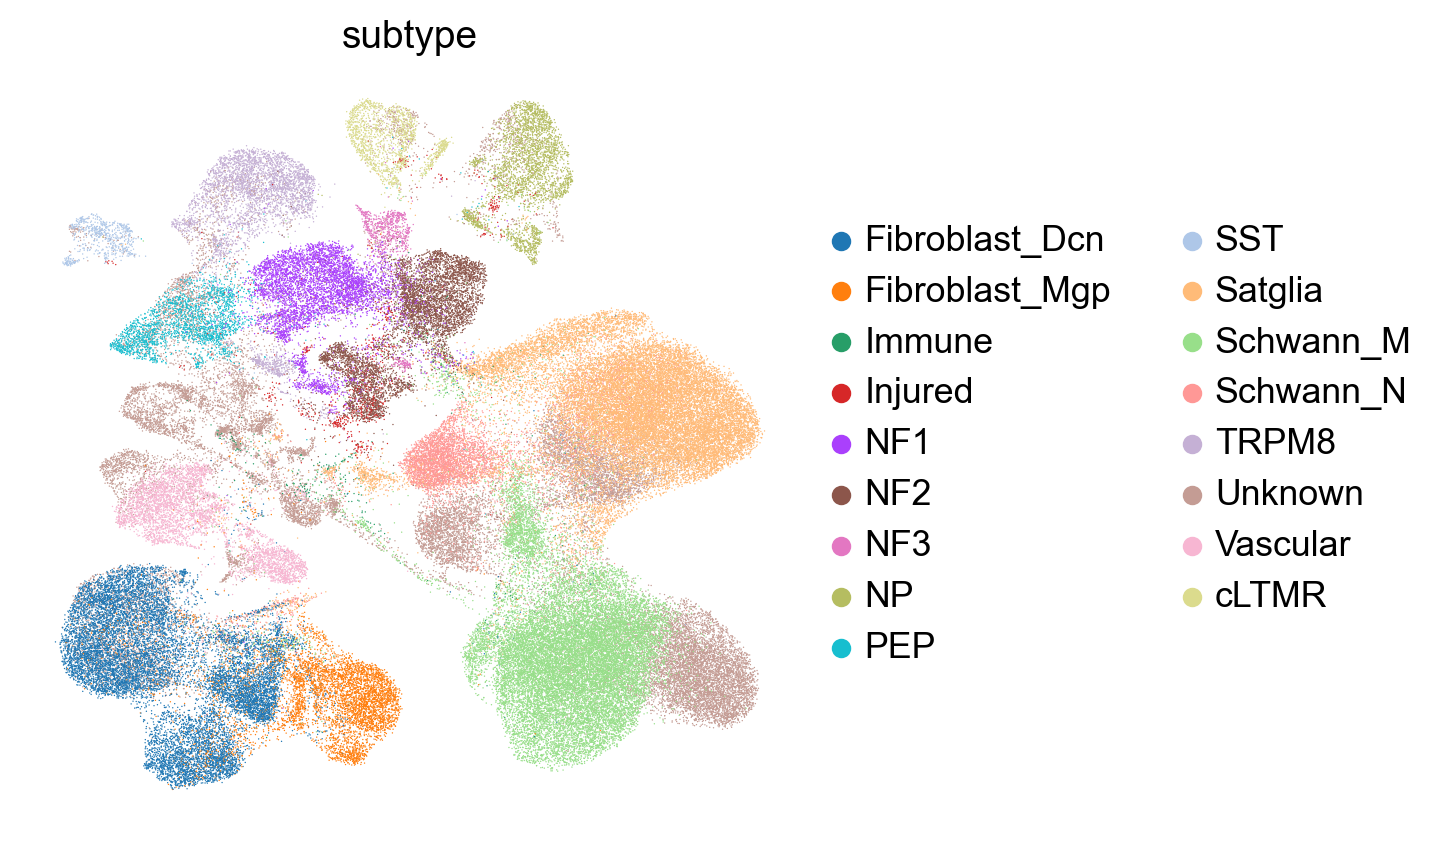

/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


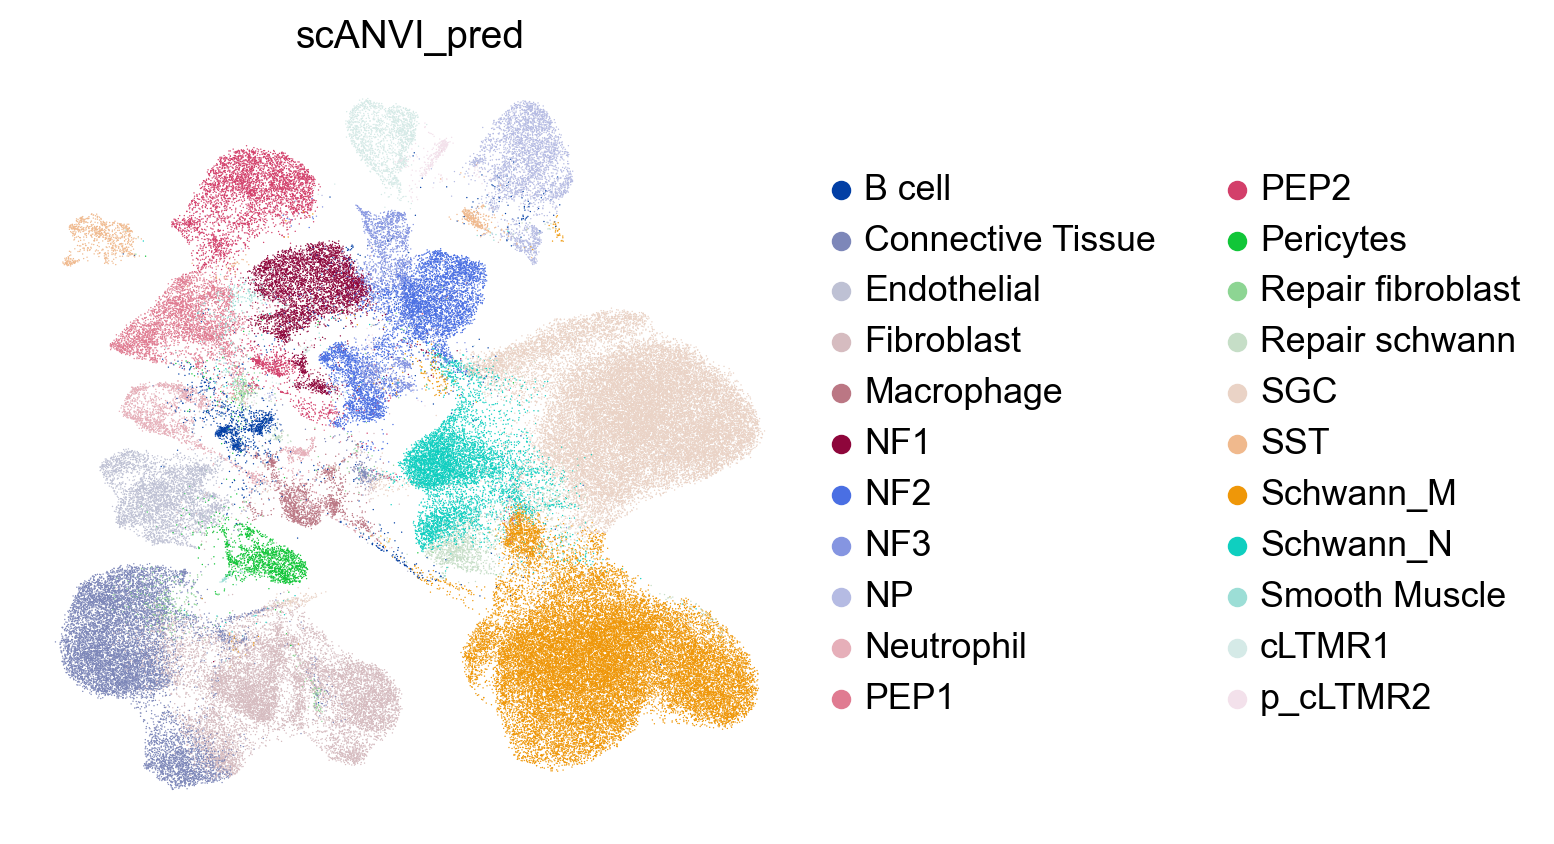

In [154]:
sc.pl.umap(TG_rna, color="subtype")
sc.pl.umap(TG_rna, color="scANVI_pred")

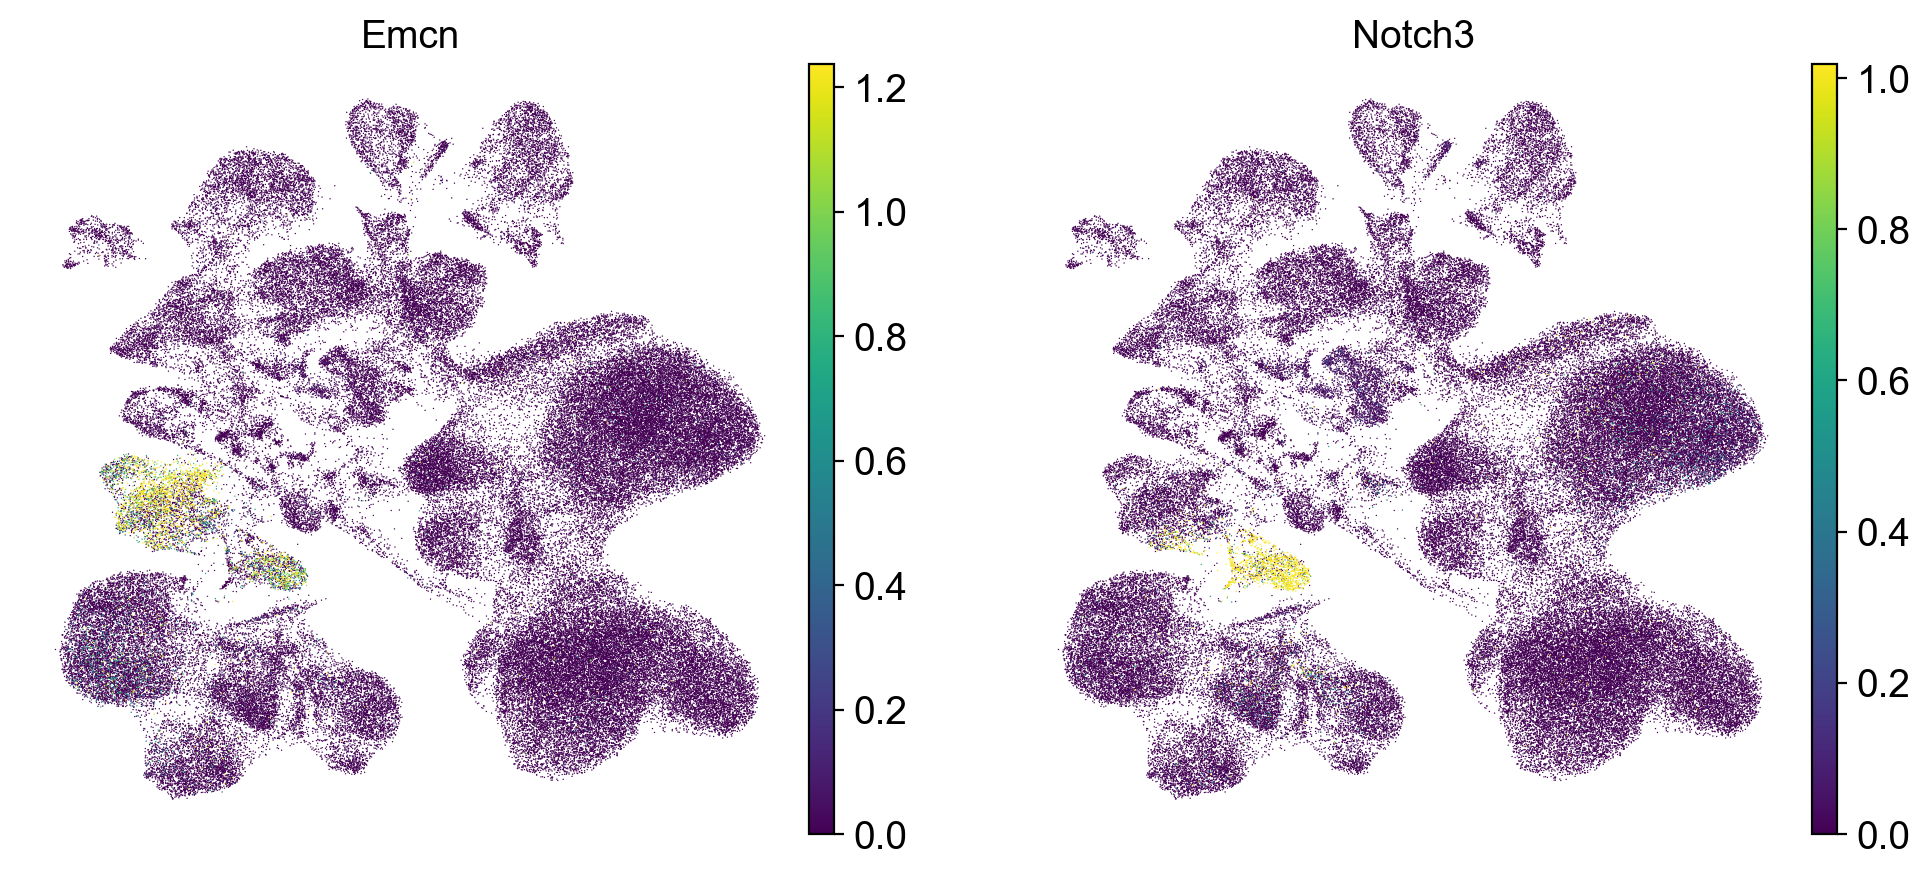

In [157]:
sc.pl.umap(TG_rna, color=["Emcn",'Notch3'], vmax='p99')

In [3]:
atac_sub_dict = {'Fibroblast_Mgp':'Fibroblast', 'PEP':'PEP1', 'TRPM8':'PEP2', 'cLTMR':'cLTMR1', 'Satglia':'SGC', 'Vascular':'Endothelial'}

In [4]:
TG_atac.obs['scANVI_pred'] = TG_atac.obs.subtype.map(lambda x: atac_sub_dict.get(x, x))

/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


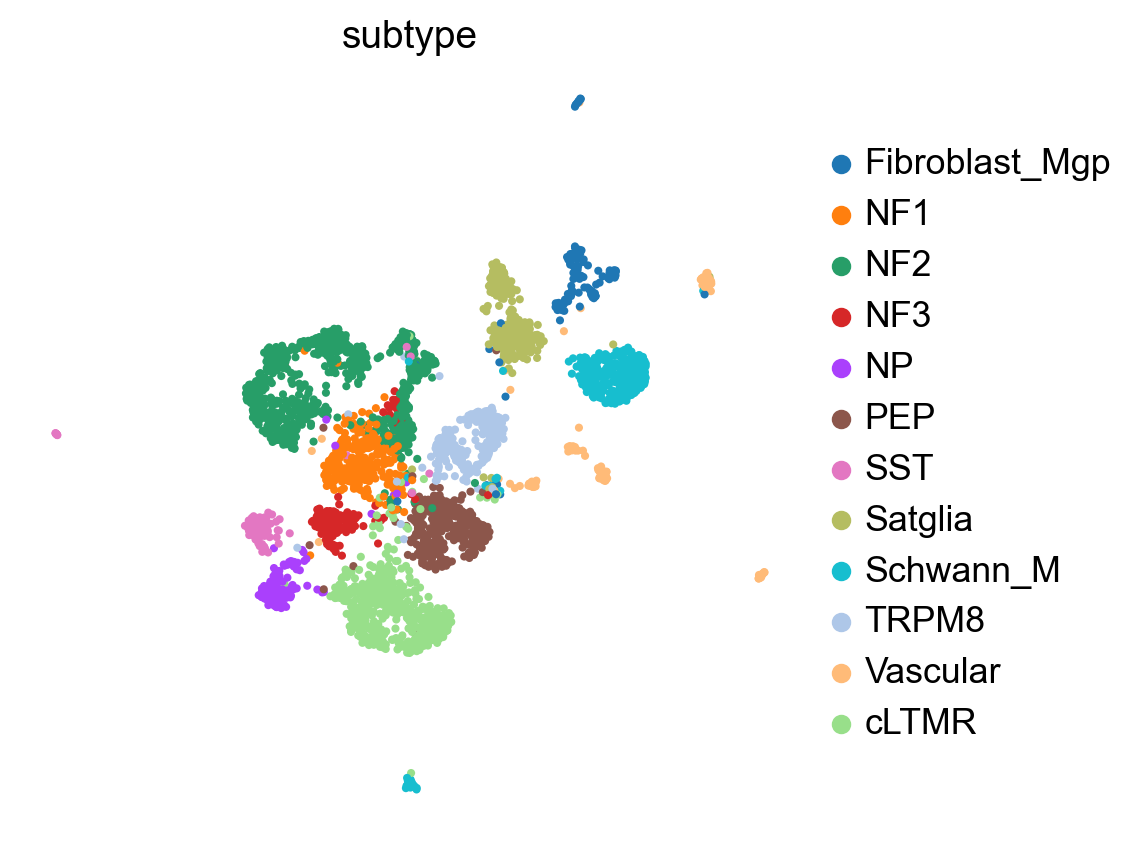

/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


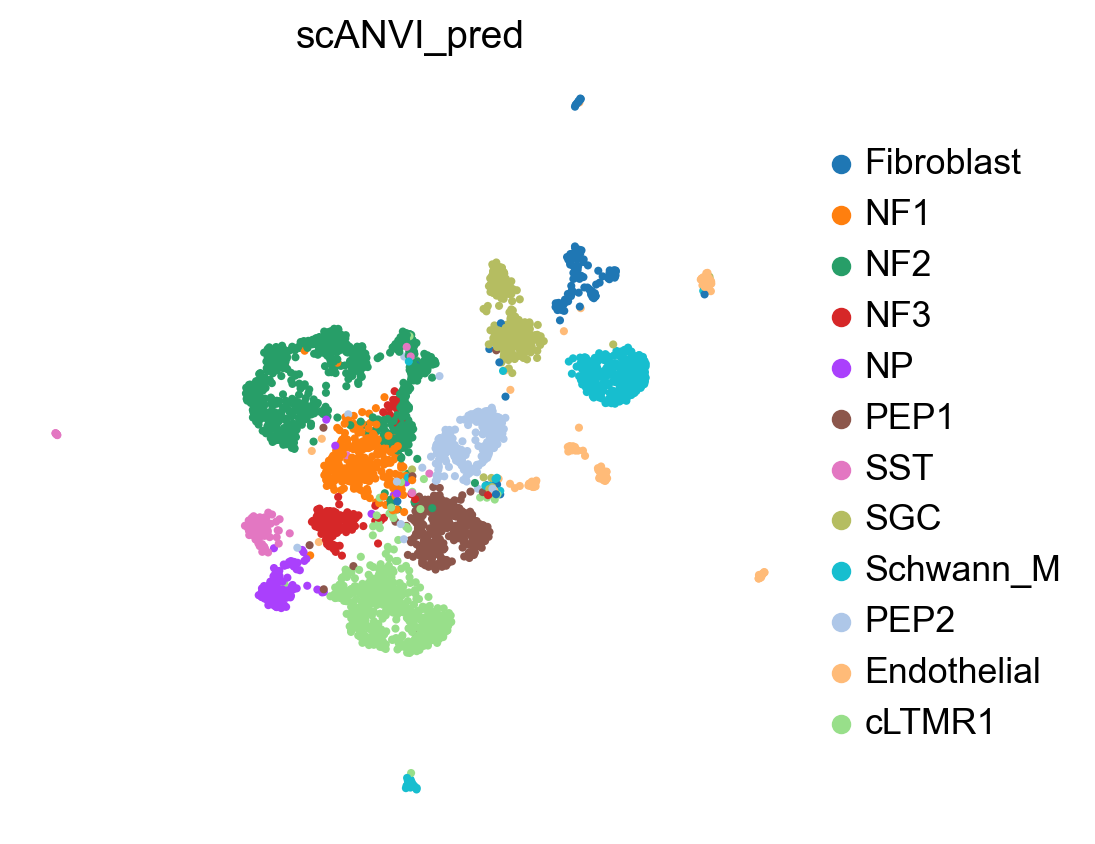

In [5]:
sc.pl.umap(TG_atac, color="subtype")
sc.pl.umap(TG_atac, color="scANVI_pred")

In [6]:
TG_rna.write("../TG_data/Results/TG_rna_pp.h5ad", compression="gzip")
TG_atac.write("../TG_data/Results/TG_atac_pp.h5ad", compression="gzip")
nx.write_graphml(guidance, "../TG_data/Results/guidance.graphml.gz")

In [2]:
TG_rna = sc.read_h5ad("../TG_data/Results/TG_rna_pp.h5ad")

In [3]:
markers = {
    'B cell': ['Cd79a', 'Ighd'],
    'Connective Tissue': ['Gpc3','Dcn'],
    'Endothelial': ['Pecam1','Cldn5'],
    'Fibroblast': ['Dcn','Mgp'],
    'Macrophage': ['Lyz2','Mrc1'],
    'NF1': ['Nefh','Hapln4','Htr3a','Cplx2'],
    'NF2': ['Nefh','Hapln4','Pvalb','Calb1'],
    'NF3': ['Nefh','Cadps2','Ntrk2'],
    'NP': ['Cd55','Mrgprd','Lpar3'],
    'Neutrophil': ['S100a8','Retnlg'],
    'PEP1': ['Tac1','Gpx3','Cartpt'],
    'PEP2': ['Tac1','Hpca','Trpm8'],
    'Pericytes': ['Pdgfrb','Notch3'],
    'SGC': ['Apoe','Fabp7','Ednrb'],
    'SST': ['Nppb','Sst','Il31ra'],
    'Smooth Muscle': ['Crip1','Aoc3'],
    'cLTMR1': ['Kif5c','Th'],
    'p_cLTMR2': ['Adamts9','Th'],
}

In [4]:
sc.tl.dendrogram(TG_rna, groupby='scANVI_pred', use_rep='X_scANVI')

Storing dendrogram info using `.uns['dendrogram_scANVI_pred']`


In [9]:
TG_rna.X = TG_rna.layers['counts'].copy()
sc.pp.normalize_total(TG_rna)
sc.pp.log1p(TG_rna)

normalizing counts per cell
    finished (0:00:00)


categories: B cell, Connective Tissue, Endothelial, etc.
var_group_labels: B cell, Connective Tissue, Endothelial, etc.


/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


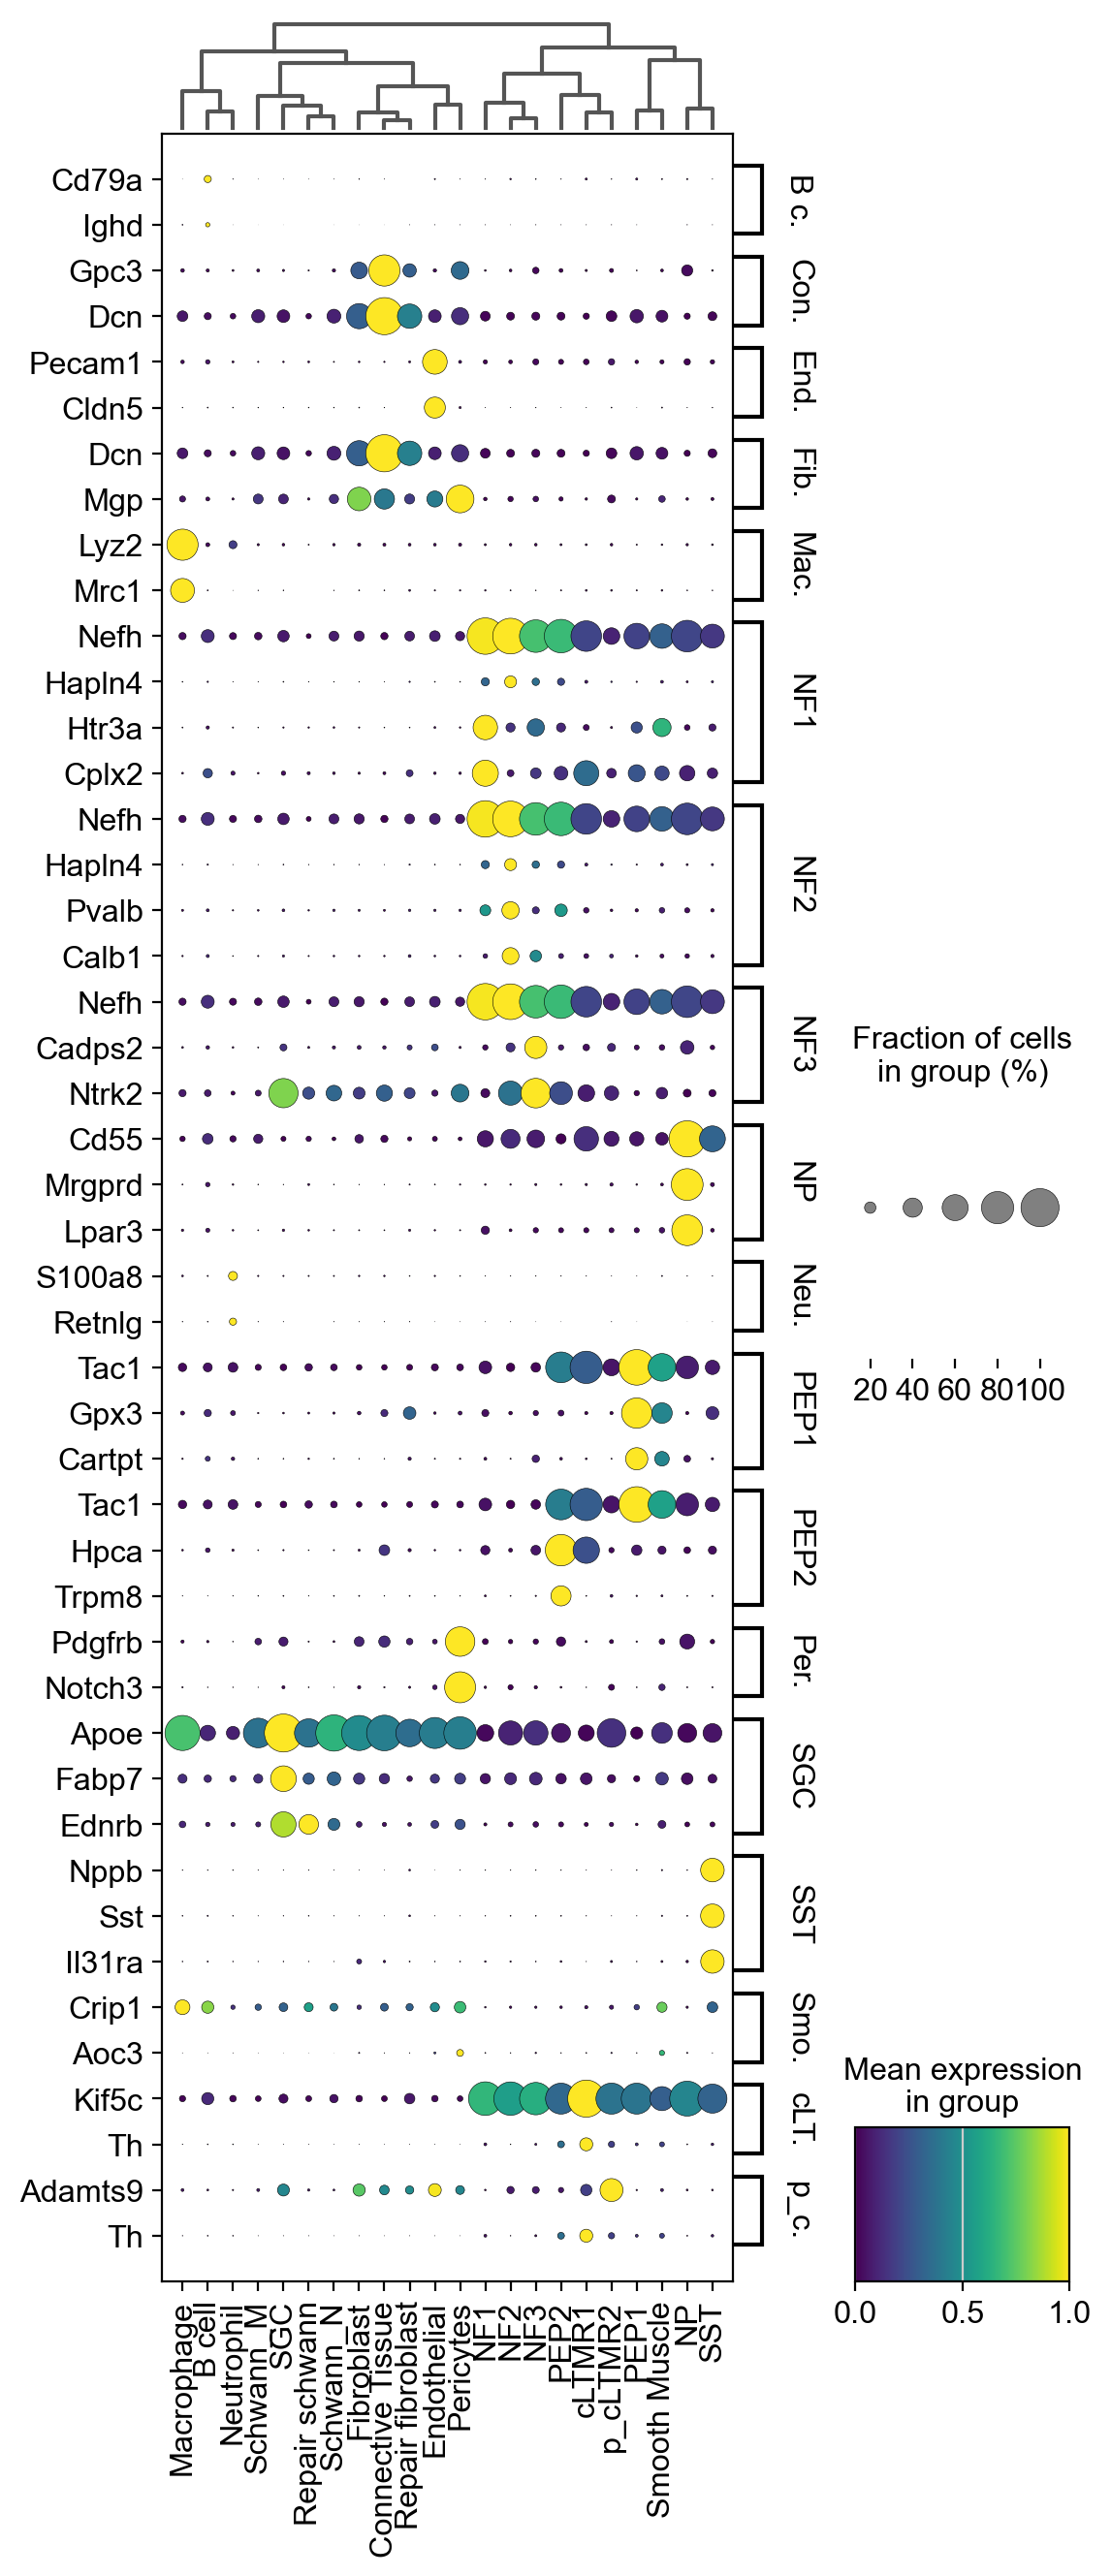

In [15]:
sc.pl.dotplot(
    TG_rna,
    markers,
    groupby = "scANVI_pred",
    dendrogram = True,
    color_map = "viridis",
    swap_axes = True,
    use_raw = False,
    standard_scale = "var",
    figsize=(6,15),
    # save = "scRNA-seq_dotplot.pdf"
)